# Visualize Code Generation Results - Reflection Results

1. 15 small language models (SLMs) were tested on 4 code generation datasets.
2. Metric used - Pass@1
3. This notebooks load raw results, visualizes them by dataset, and ranks the models based on their average performance.
4. Alternatively, it applies the MinMaxScaler to normalize the results and then rank SLMs.

__Candiates for removal__ for the reflection workflow cycle:
* Mistral 7B (lowest results)
* Mistral codestral_mamba - discontinued by Mistral AI because API call to list all the available models doesn't contain this one, only the 22B codstral model and the codestral embeddings model.
* Solar-10.7B (10.7B model, but low results).
* Phixtral-4x2_8 (duplicates the results of Phixtral-2x2_8).
* Mistral Nemo (12B model - largest among all, but it performs at the level of 7~8B models). SINCE CODESTRAL_MAMBA IS DISCONTINUED, I MIGHT AS WELL KEEP NEMO

In [3]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
%load_ext autoreload
%autoreload 2

pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 500)

# PART 1. Load Results and Scale the Four Datasets

In [4]:
model_cols = [
    'phixtral-2x2_8', 'Llama-3.1-8B', 'Codegemma-7b-it',
    'deepseek-coder-6.7b', 'OpenCodeInterpreter-DS-6.7B',
    'Artigenz-Coder-DS-6.7B', 'CodeQwen1.5-7B-Chat', 'Nxcode-CQ-7B-orpo',
    'mistral_3b', 'mistral_8B', 'mistral_nemo',
]
param_cols = ['#', 'dataset', 'prompt', 'cleaning', 'temperature', 'top_p']

In [5]:
# load all data
file = '/Users/andrew/Documents/04_git/code-generation/0_documents/2_docs/indiv_model_results_20250529.xlsx'
sheet_names = [
    'HumanEval', 'BigCode', 'MBPP', 'LBPP',
    'HumanEval_Reflection', 'BigCode_Reflection', 'MBPP_Reflection', 'LBPP_Reflection',]
res_raw = dict()
for sheet_name in sheet_names:
    df = pd.read_excel( file, sheet_name=sheet_name )
    res_raw[sheet_name] = df[ param_cols + model_cols ]
print('Datasets:', ', '.join(list(res_raw.keys())))
print(res_raw['HumanEval_Reflection'].shape)
res_raw['HumanEval']

Datasets: HumanEval, BigCode, MBPP, LBPP, HumanEval_Reflection, BigCode_Reflection, MBPP_Reflection, LBPP_Reflection
(12, 17)


,#,dataset,prompt,cleaning,temperature,top_p,phixtral-2x2_8,Llama-3.1-8B,Codegemma-7b-it,deepseek-coder-6.7b,OpenCodeInterpreter-DS-6.7B,Artigenz-Coder-DS-6.7B,CodeQwen1.5-7B-Chat,Nxcode-CQ-7B-orpo,mistral_3b,mistral_8B,mistral_nemo
0,1,human_eval,basic_prompt,raw,1,1,0.500000,0.000000,0.000000,0.774390,0.743902,0.750000,0.000000,0.000000,0.000000,0.000000,0.487805
1,2,human_eval,basic_prompt,partial,1,1,0.500000,0.701220,0.609756,0.786585,0.762195,0.756098,0.817073,0.823171,0.774390,0.792683,0.689024
2,3,human_eval,basic_prompt,full,1,1,0.512195,0.707317,0.609756,0.780488,0.762195,0.750000,0.823171,0.829268,0.768293,0.786585,0.682927
3,4,human_eval,basic_prompt,full_light,1,1,0.506098,0.701220,0.609756,0.786585,0.762195,0.756098,0.817073,0.823171,0.774390,0.792683,0.689024
4,5,human_eval,prompt,raw,1,1,0.024390,0.000000,0.000000,0.024390,0.006098,0.725610,0.000000,0.000000,0.000000,0.000000,0.000000
5,6,human_eval,prompt,partial,1,1,0.463415,0.658537,0.554878,0.817073,0.768293,0.768293,0.786585,0.768293,0.091463,0.804878,0.695122
6,7,human_eval,prompt,full,1,1,0.554878,0.682927,0.585366,0.810976,0.762195,0.762195,0.841463,0.829268,0.756098,0.804878,0.689024
7,8,human_eval,prompt,full_light,1,1,0.560976,0.670732,0.585366,0.817073,0.768293,0.768293,0.841463,0.829268,0.756098,0.804878,0.695122
8,9,human_eval,full_prompt,raw,1,1,0.048780,0.000000,0.000000,0.000000,0.000000,0.609756,0.000000,0.000000,0.000000,0.000000,0.000000
9,10,human_eval,full_prompt,partial,1,1,0.256098,0.585366,0.512195,0.725610,0.713415,0.682927,0.756098,0.750000,0.640244,0.731707,0.323171


In [6]:
# select 15 SLM model columns and add index for convenience
res_raw_short = dict()

for key in res_raw:
    df = res_raw[key]

    score_cols = [c for c in df.columns if c not in param_cols]
    short_df = df[score_cols].apply(pd.to_numeric, errors='coerce').astype(float)

    # Rebuild MultiIndex
    mi = pd.MultiIndex.from_frame(df[['prompt', 'cleaning']])
    short_df.index = mi
    short_df.index.names = ['prompt', 'cleaning']
    short_df.loc[('max', 'max'), score_cols] = short_df.max(axis=0)

    # Save
    res_raw_short[key] = short_df

print('Datasets:', ', '.join(list(res_raw_short.keys())))
print(res_raw_short['HumanEval'].shape)
res_raw_short['HumanEval']

Datasets: HumanEval, BigCode, MBPP, LBPP, HumanEval_Reflection, BigCode_Reflection, MBPP_Reflection, LBPP_Reflection
(13, 11)


phixtral-2x2_8  Llama-3.1-8B  Codegemma-7b-it  \
prompt       cleaning                                                    
basic_prompt raw               0.500000      0.000000         0.000000   
             partial           0.500000      0.701220         0.609756   
             full              0.512195      0.707317         0.609756   
             full_light        0.506098      0.701220         0.609756   
prompt       raw               0.024390      0.000000         0.000000   
             partial           0.463415      0.658537         0.554878   
             full              0.554878      0.682927         0.585366   
             full_light        0.560976      0.670732         0.585366   
full_prompt  raw               0.048780      0.000000         0.000000   
             partial           0.256098      0.585366         0.512195   
             full              0.548780      0.585366         0.542683   
             full_light        0.542683      0.585366         0.542683   
max          max               0.560976      0.707317         0.609756   

                         deepseek-coder-6.7b  OpenCodeInterpreter-DS-6.7B  \
prompt       cleaning                                                       
basic_prompt raw                    0.774390                     0.743902   
             partial                0.786585                     0.762195   
             full                   0.780488                     0.762195   
             full_light             0.786585                     0.762195   
prompt       raw                    0.024390                     0.006098   
             partial                0.817073                     0.768293   
             full                   0.810976                     0.762195   
             full_light             0.817073                     0.768293   
full_prompt  raw                    0.000000                     0.000000   
             partial                0.725610                     0.713415   
             full                   0.725610                     0.719512   
             full_light             0.725610                     0.719512   
max          max                    0.817073                     0.768293   

                         Artigenz-Coder-DS-6.7B  CodeQwen1.5-7B-Chat  \
prompt       cleaning                                                  
basic_prompt raw                       0.750000             0.000000   
             partial                   0.756098             0.817073   
             full                      0.750000             0.823171   
             full_light                0.756098             0.817073   
prompt       raw                       0.725610             0.000000   
             partial                   0.768293             0.786585   
             full                      0.762195             0.841463   
             full_light                0.768293             0.841463   
full_prompt  raw                       0.609756             0.000000   
             partial                   0.682927             0.756098   
             full                      0.695122             0.780488   
             full_light                0.695122             0.780488   
max          max                       0.768293             0.841463   

                         Nxcode-CQ-7B-orpo  mistral_3b  mistral_8B  \
prompt       cleaning                                                
basic_prompt raw                  0.000000    0.000000    0.000000   
             partial              0.823171    0.774390    0.792683   
             full                 0.829268    0.768293    0.786585   
             full_light           0.823171    0.774390    0.792683   
prompt       raw                  0.000000    0.000000    0.000000   
             partial              0.768293    0.091463    0.804878   
             full                 0.829268    0.756098    0.804878   
             full_light           0.829268    0

In [8]:
# load all data
file = '/Users/andrew/Documents/04_git/code-generation/0_documents/2_docs/indiv_model_results_multiagent_20250529.xlsx'
sheet_names = ['HumanEval_Multiagent', 'BigCode_Multiagent', 'MBPP_Multiagent', 'LBPP_Multiagent',]
res_raw2 = dict()
for sheet_name in sheet_names:
    res_raw2[sheet_name] = pd.read_excel( file, sheet_name=sheet_name )
print('Datasets:', ', '.join(list(res_raw2.keys())))
print(res_raw2['HumanEval_Multiagent'].shape)
res_raw2['HumanEval_Multiagent']

Datasets: HumanEval_Multiagent, BigCode_Multiagent, MBPP_Multiagent, LBPP_Multiagent
(12, 17)


,#,dataset,prompt,cleaning,temperature,top_p,phixtral-2x2_8,Llama-3.1-8B,Codegemma-7b-it,deepseek-coder-6.7b,OpenCodeInterpreter-DS-6.7B,Artigenz-Coder-DS-6.7B,CodeQwen1.5-7B-Chat,Nxcode-CQ-7B-orpo,mistral_3b,mistral_8B,mistral_nemo
0,1,mbpp_multiagent,basic_prompt,raw,1,1,0.137023,0.000000,0.000000,0.115771,0.355739,0.477700,0.000000,0.000000,0.000000,0.000000,0.000000
1,2,mbpp_multiagent,basic_prompt,partial,1,1,0.306637,0.500263,0.556300,0.728983,0.718940,0.747930,0.824976,0.831185,0.777178,0.789516,0.707213
2,3,mbpp_multiagent,basic_prompt,full,1,1,0.320610,0.529960,0.566022,0.717963,0.721575,0.766330,0.830621,0.841923,0.750128,0.775775,0.694817
3,4,mbpp_multiagent,basic_prompt,full_light,1,1,0.308592,0.518358,0.657595,0.730071,0.726546,0.740405,0.821596,0.853794,0.766396,0.789918,0.699731
4,5,mbpp_multiagent,prompt,raw,1,1,0.000000,0.000000,0.000000,0.000000,0.000000,0.165083,0.000000,0.000000,0.000000,0.000000,0.000000
5,6,mbpp_multiagent,prompt,partial,1,1,0.564858,0.589924,0.499325,0.801824,0.745208,0.718567,0.797662,0.806479,0.135307,0.717619,0.641637
6,7,mbpp_multiagent,prompt,full,1,1,0.576783,0.723757,0.519952,0.786573,0.740312,0.731743,0.847963,0.841174,0.773479,0.811447,0.657737
7,8,mbpp_multiagent,prompt,full_light,1,1,0.591852,0.736150,0.517160,0.832627,0.755843,0.796775,0.846173,0.835203,0.763383,0.806471,0.648387
8,9,mbpp_multiagent,full_prompt,raw,1,1,0.000000,0.000000,0.000000,0.000000,0.000000,0.183131,0.000000,0.000000,0.000000,0.000000,0.000000
9,10,mbpp_multiagent,full_prompt,partial,1,1,0.545911,0.557462,0.554936,0.702337,0.785596,0.720021,0.847156,0.834514,0.226739,0.706600,0.510429


In [9]:
# select 15 SLM model columns and add index for convenience
res_raw_short2 = dict()
for key in res_raw2:
    df = res_raw2[key]
    param_cols = ['#', 'dataset', 'prompt', 'cleaning', 'temperature', 'top_p']
    score_cols = [c for c in df.columns if c not in param_cols]
    res_raw_short2[key] = df[score_cols].apply(pd.to_numeric, errors='coerce')

    # Rebuild MultiIndex on rows from the original prompt/cleaning columns
    mi = pd.MultiIndex.from_frame(df[['prompt','cleaning']])
    res_raw_short2[key].index = mi
    res_raw_short2[key].index.names = ['prompt','cleaning']
print('Datasets:', ', '.join(list(res_raw_short2.keys())))
print(res_raw_short2['HumanEval_Multiagent'].shape)
res_raw_short2['HumanEval_Multiagent']

Datasets: HumanEval_Multiagent, BigCode_Multiagent, MBPP_Multiagent, LBPP_Multiagent
(12, 11)


phixtral-2x2_8  Llama-3.1-8B  Codegemma-7b-it  \
prompt       cleaning                                                    
basic_prompt raw               0.137023      0.000000         0.000000   
             partial           0.306637      0.500263         0.556300   
             full              0.320610      0.529960         0.566022   
             full_light        0.308592      0.518358         0.657595   
prompt       raw               0.000000      0.000000         0.000000   
             partial           0.564858      0.589924         0.499325   
             full              0.576783      0.723757         0.519952   
             full_light        0.591852      0.736150         0.517160   
full_prompt  raw               0.000000      0.000000         0.000000   
             partial           0.545911      0.557462         0.554936   
             full              0.556490      0.576000         0.565745   
             full_light        0.547801      0.573502         0.545323   

                         deepseek-coder-6.7b  OpenCodeInterpreter-DS-6.7B  \
prompt       cleaning                                                       
basic_prompt raw                    0.115771                     0.355739   
             partial                0.728983                     0.718940   
             full                   0.717963                     0.721575   
             full_light             0.730071                     0.726546   
prompt       raw                    0.000000                     0.000000   
             partial                0.801824                     0.745208   
             full                   0.786573                     0.740312   
             full_light             0.832627                     0.755843   
full_prompt  raw                    0.000000                     0.000000   
             partial                0.702337                     0.785596   
             full                   0.721944                     0.747660   
             full_light             0.701402                     0.746167   

                         Artigenz-Coder-DS-6.7B  CodeQwen1.5-7B-Chat  \
prompt       cleaning                                                  
basic_prompt raw                       0.477700             0.000000   
             partial                   0.747930             0.824976   
             full                      0.766330             0.830621   
             full_light                0.740405             0.821596   
prompt       raw                       0.165083             0.000000   
             partial                   0.718567             0.797662   
             full                      0.731743             0.847963   
             full_light                0.796775             0.846173   
full_prompt  raw                       0.183131             0.000000   
             partial                   0.720021             0.847156   
             full                      0.710077             0.840086   
             full_light                0.725451             0.846793   

                         Nxcode-CQ-7B-orpo  mistral_3b  mistral_8B  \
prompt       cleaning                                                
basic_prompt raw                  0.000000    0.000000    0.000000   
             partial              0.831185    0.777178    0.789516   
             full                 0.841923    0.750128    0.775775   
             full_light           0.853794    0.766396    0.789918   
prompt       raw                  0.000000    0.000000    0.000000   
             partial              0.806479    0.135307    0.717619   
             full                 0.841174    0.773479    0.811447   
             full_light           0.835203    0.763383    0.806471   
full_prompt  raw                  0.000000    0.000000    0.000000   
             partial              0.834514    0.226739    0.706600   
             full                 0.834427    0.756020    0.

In [10]:
for key, df in res_raw_short2.items():
    print(key)
    max_val = df.max().max()
    
    # Find row and column of the max value
    full_idx = (df == max_val).stack().idxmax()

    print(f'Max: {max_val:.4f}')
    print(full_idx)

    # get mean value for 'full' and 'full_light' rows
    filtered = pd.concat([
    df.xs('full', level='cleaning', drop_level=False),
    df.xs('full_light', level='cleaning', drop_level=False)
    ])
    row_means = filtered.mean(axis=1)
    overall_mean = row_means.mean()
    print(f"Mean of row-wise means for 'full' and 'full_light': {overall_mean:.4f}\n")

HumanEval_Multiagent
Max: 0.8538
('basic_prompt', 'full_light', 'Nxcode-CQ-7B-orpo')
Mean of row-wise means for 'full' and 'full_light': 0.7036

BigCode_Multiagent
Max: 0.3637
('basic_prompt', 'partial', 'mistral_8B')
Mean of row-wise means for 'full' and 'full_light': 0.3187

MBPP_Multiagent
Max: 0.7579
('basic_prompt', 'partial', 'CodeQwen1.5-7B-Chat')
Mean of row-wise means for 'full' and 'full_light': 0.5906

LBPP_Multiagent
Max: 0.3354
('basic_prompt', 'full_light', 'OpenCodeInterpreter-DS-6.7B')
Mean of row-wise means for 'full' and 'full_light': 0.2481



In [11]:
# scale scores in each dataframe
res2 = dict()
for key, df in res_raw_short2.items():
    scaled_df = (df - df.min().min()) / (df.max().max() - df.min().min())
    res2[key] = scaled_df
print('Datasets:', ', '.join(list(res2.keys())))
print(res2['HumanEval_Multiagent'].shape)
res2['HumanEval_Multiagent']

Datasets: HumanEval_Multiagent, BigCode_Multiagent, MBPP_Multiagent, LBPP_Multiagent
(12, 11)


phixtral-2x2_8  Llama-3.1-8B  Codegemma-7b-it  \
prompt       cleaning                                                    
basic_prompt raw               0.160487      0.000000         0.000000   
             partial           0.359146      0.585929         0.651562   
             full              0.375512      0.620711         0.662949   
             full_light        0.361436      0.607122         0.770203   
prompt       raw               0.000000      0.000000         0.000000   
             partial           0.661586      0.690944         0.584831   
             full              0.675552      0.847695         0.608990   
             full_light        0.693202      0.862210         0.605719   
full_prompt  raw               0.000000      0.000000         0.000000   
             partial           0.639394      0.652923         0.649964   
             full              0.651784      0.674636         0.662625   
             full_light        0.641607      0.671710         0.638706   

                         deepseek-coder-6.7b  OpenCodeInterpreter-DS-6.7B  \
prompt       cleaning                                                       
basic_prompt raw                    0.135596                     0.416657   
             partial                0.853816                     0.842053   
             full                   0.840908                     0.845139   
             full_light             0.855090                     0.850961   
prompt       raw                    0.000000                     0.000000   
             partial                0.939131                     0.872819   
             full                   0.921267                     0.867085   
             full_light             0.975208                     0.885275   
full_prompt  raw                    0.000000                     0.000000   
             partial                0.822607                     0.920123   
             full                   0.845571                     0.875691   
             full_light             0.821512                     0.873942   

                         Artigenz-Coder-DS-6.7B  CodeQwen1.5-7B-Chat  \
prompt       cleaning                                                  
basic_prompt raw                       0.559503             0.000000   
             partial                   0.876007             0.966246   
             full                      0.897558             0.972858   
             full_light                0.867194             0.962288   
prompt       raw                       0.193352             0.000000   
             partial                   0.841616             0.934255   
             full                      0.857049             0.993170   
             full_light                0.933216             0.991073   
full_prompt  raw                       0.214490             0.000000   
             partial                   0.843318             0.992225   
             full                      0.831672             0.983944   
             full_light                0.849679             0.991799   

                         Nxcode-CQ-7B-orpo  mistral_3b  mistral_8B  \
prompt       cleaning                                                
basic_prompt raw                  0.000000    0.000000    0.000000   
             partial              0.973519    0.910264    0.924715   
             full                 0.986096    0.878582    0.908621   
             full_light           1.000000    0.897636    0.925186   
prompt       raw                  0.000000    0.000000    0.000000   
             partial              0.944582    0.158477    0.840505   
             full                 0.985219    0.905931    0.950401   
             full_light           0.978225    0.894107    0.944573   
full_prompt  raw                  0.000000    0.000000    0.000000   
             partial              0.977419    0.265567    0.827600   
             full                 0.977316    0.885482    0.

In [12]:
# plot using the max values
plt.style.use('ggplot')
baseline   = 'HumanEval'    #'HumanEval'   'MBPP'  'LBPP'  'BigCode'   
reflection = baseline + '_Multiagent'

sorted_models = res_raw_short[baseline].columns
y1 = res_raw_short[baseline].loc[('max', 'max')].values
y2 = res_raw_short2[reflection].loc[('max', 'max')].values
improvement = (sum(y2)-sum(y1))/11
phrase = f'Average improvement: {round(improvement*100, 2)}%'

# sort by y1
sorted_indices = y1.argsort()
y1_sorted = y1[sorted_indices]
y2_sorted = y2[sorted_indices]
models_sorted = sorted_models[sorted_indices]

plt.figure(figsize=(10, 6))
for label, points in [('baseline', y1_sorted), ('reflection', y2_sorted)]:
    plt.plot(range(len(models_sorted)), points, marker='o', label=label)
plt.title(f'Baseline vs. Reflection: {baseline}')
plt.xticks(range(len(models_sorted)), labels=models_sorted, rotation=45, ha='right')
plt.ylabel('Pass@1 Score')
plt.legend(title='Cleaning')

plt.text(0.5, 0.1, phrase, transform=plt.gca().transAxes,
         fontsize=12, ha='center', va='center',)# fontweight='bold')

plt.tight_layout()
plt.show()

KeyError: 'max'

In [155]:
res_raw_short.keys()

dict_keys(['HumanEval', 'BigCode', 'MBPP', 'LBPP', 'HumanEval_Reflection', 'BigCode_Reflection', 'MBPP_Reflection', 'LBPP_Reflection'])

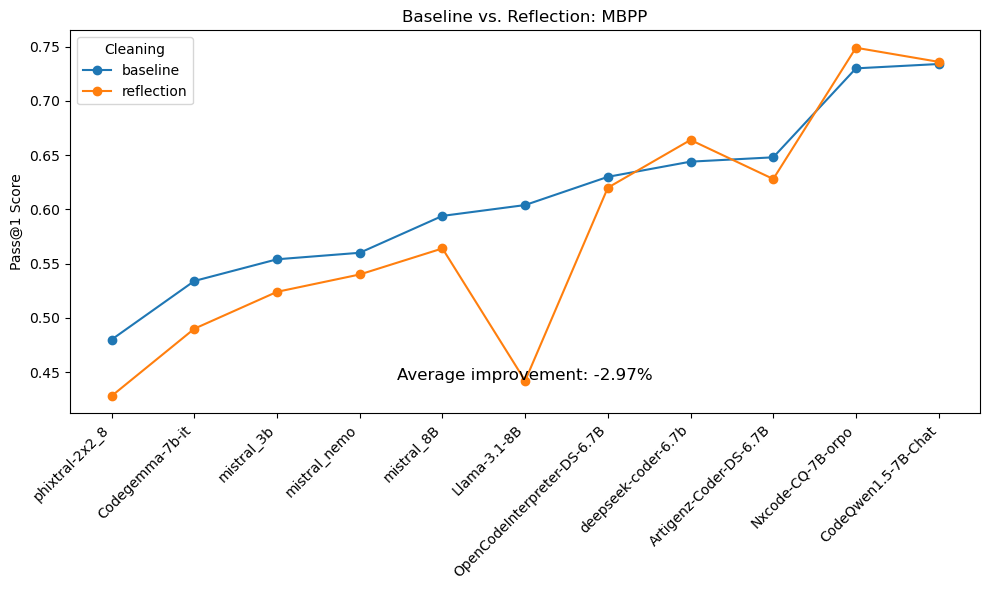

In [156]:
# plot using the most frequent indices
baseline   = 'MBPP'    #'LBPP'    #'HumanEval'
reflection = baseline + '_Reflection'

sorted_models = res_raw_short[baseline].columns
y1 = res_raw_short[baseline].loc[('basic_prompt', 'full')].values
y2 = res_raw_short[reflection].loc[('basic_prompt', 'full_light')].values
improvement = (sum(y2)-sum(y1))/11
phrase = f'Average improvement: {round(improvement*100, 2)}%'

# sort by y1
sorted_indices = y1.argsort()
y1_sorted = y1[sorted_indices]
y2_sorted = y2[sorted_indices]
models_sorted = sorted_models[sorted_indices]

plt.figure(figsize=(10, 6))
for label, points in [('baseline', y1_sorted), ('reflection', y2_sorted)]:
    plt.plot(range(len(models_sorted)), points, marker='o', label=label)
plt.title(f'Baseline vs. Reflection: {baseline}')
plt.xticks(range(len(models_sorted)), labels=models_sorted, rotation=45, ha='right')
plt.ylabel('Pass@1 Score')
plt.legend(title='Cleaning')

plt.text(0.5, 0.1, phrase, transform=plt.gca().transAxes,
         fontsize=12, ha='center', va='center',)# fontweight='bold')

plt.tight_layout()
plt.show()